In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from PIL import Image


In [ ]:
dataset_choice = "mnist"
epochs = 60
batch_size = 64
noise_dim = 100
lr_G = 0.0002
lr_D = 0.0001
sample_interval = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("generated_samples", exist_ok=True)
os.makedirs("final_generated_images", exist_ok=True)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(
        root="./data",
        train=True,
        transform=transform,
        download=True
    ),
    batch_size=batch_size,
    shuffle=True
)


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),

            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(img.size(0), 1, 28, 28)


In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 1)
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)


In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCEWithLogitsLoss()

optimizer_G = optim.Adam(generator.parameters(), lr=lr_G, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr_D, betas=(0.5, 0.999))


In [ ]:
for epoch in range(1, epochs + 1):
    for imgs, _ in train_loader:

        real_imgs = imgs.to(device)
        b = real_imgs.size(0)

        real_labels = torch.full((b, 1), 0.9, device=device)   # label smoothing
        fake_labels = torch.zeros(b, 1, device=device)

        # ---- Train Discriminator ----
        optimizer_D.zero_grad()

        real_out = discriminator(real_imgs)
        real_loss = criterion(real_out, real_labels)

        z = torch.randn(b, noise_dim, device=device)
        fake_imgs = generator(z)

        fake_out = discriminator(fake_imgs.detach())
        fake_loss = criterion(fake_out, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # ---- Train Generator ----
        optimizer_G.zero_grad()

        fake_out = discriminator(fake_imgs)
        g_loss = criterion(fake_out, real_labels)

        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch [{epoch}/{epochs}] D_loss: {d_loss.item():.4f} G_loss: {g_loss.item():.4f}")

    if epoch % sample_interval == 0:
        z = torch.randn(25, noise_dim, device=device)
        samples = generator(z)
        grid = make_grid(samples, nrow=5, normalize=True)
        save_image(grid, f"generated_samples/epoch_{epoch}.png")


In [ ]:
 z = torch.randn(100, noise_dim, device=device)
final_images = generator(z)

for i in range(100):
    save_image(final_images[i], f"final_generated_images/image_{i+1}.png", normalize=True)

print("Training complete. Final images saved.")


In [ ]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
classifier = MNISTClassifier().to(device)
optimizer_C = optim.Adam(classifier.parameters(), lr=0.001)
criterion_C = nn.CrossEntropyLoss()

classifier.train()
for ep in range(3):
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer_C.zero_grad()
        loss = criterion_C(classifier(imgs), labels)
        loss.backward()
        optimizer_C.step()

print("Classifier trained.")


In [ ]:
classifier.eval()
with torch.no_grad():
    gan_preds = classifier(final_images).argmax(dim=1)

print("Predictions on GAN images (first 20):")
print(gan_preds[:20].tolist())


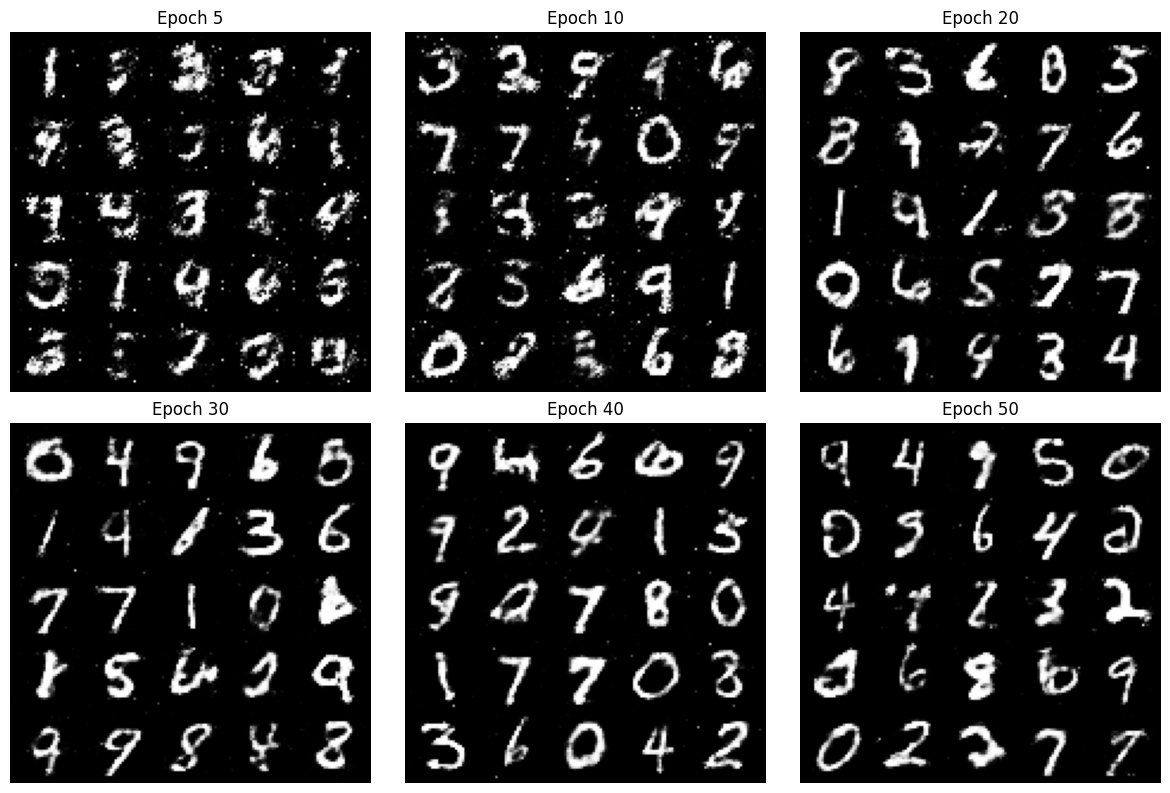

In [31]:
epochs_to_show = [5, 10, 20, 30, 40, 50]

plt.figure(figsize=(12, 8))

for i, ep in enumerate(epochs_to_show):
    img = Image.open(f"generated_samples/epoch_{ep}.png")
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Epoch {ep}")

plt.tight_layout()
plt.show()
